Introduction to Text Mining and NLP 

Shaney Sze, Luis Quiñones

BSE DSDM T2 2023

In [1245]:
from langdetect import detect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scrape_genius import get_lyrics
import re
from  urllib import request
from collections import Counter
from wordcloud import WordCloud
import statsmodels.api as sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, train_test_split, HalvingGridSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE

In [1246]:
df_grammy = pd.read_csv('grammy_df.csv')

In [1247]:
df_grammy

,title,artist,winner,year
0,Nel Blu Dipinto Di Blu (Volare),Domenico Modugno,1,1958
1,Catch A Falling Star,Perry Como,0,1958
2,Witchcraft (Single),Frank Sinatra,0,1958
3,The Chipmunk Song,David Seville And The Chipmunks,0,1958
4,Fever (Single),Peggy Lee,0,1958
...,...,...,...,...
341,Woman,Doja Cat,0,2022
342,You And Me On The Rock,Brandi Carlile Featuring Lucius,0,2022
343,Good Morning Gorgeous,Mary J. Blige,0,2022
344,Easy On Me,Adele,0,2022


In [1248]:
pattern = r"\s*(\([^)]*\)|\[.*\]|Single|Track|/)\s*"
df_grammy['title'] = df_grammy['title'].astype(str).apply(lambda x: re.sub(pattern, "", x))


In [1249]:
#get_lyrics(df_grammy, 'artist', 'title', 'zQfMBoP2o8SslZ3AYsbHhL7kbms_iOXuMkSbpxG9ixY4C0h1goZPBPZYchySHLKS')

In [1250]:
df = pd.read_csv('genius_grammy.csv')

In [1251]:
df.dropna(inplace=True)


## Preprocessing Lyrics

We decided to tokenize our text and lemmatize, stemming did not seem to improve our model, so we removed from preprocessing, 

In [1252]:
def preprocess_text(text):
    # Remove newlines and other whitespace characters
    text = re.sub(r'\s+', ' ', text)

    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
     # Tokenize the text into individual words
    tokens = word_tokenize(text)

    # Remove stop words and lowercase the words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token.lower() for token in tokens if token.lower() not in stop_words]

    # Remove any words that match the pattern "translation" followed by any letters
    filtered_tokens = [token for token in filtered_tokens if not re.match(r"translation\w+", token)]

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text


In [1253]:
df['preprocessed_lyrics'] = df['song_lyrics'].apply(preprocess_text)

Here we remove words that are not part of the actual lyrics, and are just structure of text, the genius API is supposed to handle these but it is not consistant. 

In [1254]:
words = ["chorus", "choru","lyric","song","intro", "verse", "bridge","outro", "embed", "perma", "source", "via" "top 1000", "top 10", "top 100"]
p = '|'.join(words)
p2 = re.compile(p)
df['preprocessed_lyrics'] = [p2.sub('', text) for text in df['preprocessed_lyrics']]

The Genius API can be unreliable and we got some results that were not the lyrics we wanted, so we are removing these outliers. 

In [1255]:
df = df[df['preprocessed_lyrics'].str.len() <= 1000]

Some songs were not in the english language and we decided to fcus our project in english language sentiment analysis, so we filtered out non English lyrics.

In [1256]:
# Identify language of each lyric using langdetect
df['language'] = df['preprocessed_lyrics'].apply(detect)

# Filter out non-English lyrics
df = df[df['language'] == 'en']


In [1257]:
df.dropna(axis=1, inplace=True)

if df['preprocessed_lyrics'].dtype != 'object':
    df['preprocessed_lyrics'] = df['preprocessed_lyrics'].astype(str)

We had some duplicates for artist, title, and year, so we drop these. 

In [1258]:
df.drop_duplicates(['title','artist', 'year'], inplace=True)

Function that read NRC-Lexicon.

In [1259]:
def read_lexicon(filename):
    word_sentiments = {}

    # Parse lexicon file
    with open(filename, 'r') as f:
        for line in f:
            # Ignore blank lines
            if line.strip():
                word, sentiment, value = line.split()
                if value == '1':
                    # Add sentiment to dictionary
                    cur_list = word_sentiments.get(word, [])
                    cur_list.append(sentiment)
                    word_sentiments[word] = cur_list

    return word_sentiments

Getting seniment perecentages, assigning weight based on the tfidf vectorizer.

In [1260]:
def get_sentiment_percentages(track_df, sentiment, vectorizer):
    sentiment_pcts = []

    # Get the vocabulary and IDF weights from the vectorizer
    vocabulary = vectorizer.vocabulary_
    idf_weights = vectorizer.idf_

    # Parse tracks
    for title in track_df.index.values:
        num_sentiment_words = 0
        sentiment_score = 0
        all_words = str(track_df.loc[title]['preprocessed_lyrics']).split()

        # Parse words in lyrics
        for word in all_words:
            if sentiment in word_sentiments_dict.get(word, []):
                # Adjust the sentiment score based on the TF-IDF weight of the word
                word_index = vocabulary.get(word, -1)
                if word_index >= 0:
                    word_weight = idf_weights[word_index]
                    sentiment_score += word_weight
                num_sentiment_words += 1

        if num_sentiment_words > 0:
            sentiment_pcts.append(sentiment_score/num_sentiment_words)
        else:
            sentiment_pcts.append(0)

    return pd.DataFrame(data=sentiment_pcts, index=track_df.index.values, columns=[sentiment + '_pct'])



Instantiating our tfidf with a max_df and min_df and calling our function.

In [1261]:
#Initialize sentiment dictionary and track dataframe
word_sentiments_dict = read_lexicon('lexicon.txt')

# Create a TfidfVectorizer object
tfidf = TfidfVectorizer(max_df=0.95, min_df=2)

# Fit the vectorizer to preprocessed lyrics
tfidf.fit(df['preprocessed_lyrics'])

#Generate sentiment percentages based on NRC Lexicon sentiments
sentiments = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']
for sentiment  in sentiments:
    sentiment_df = get_sentiment_percentages(df, sentiment, tfidf)
    df = df.join(sentiment_df)

We calculated our gloom index based on the weights given by the tfidf and the lyrical length of each lyrical content, scaling it to 100.

In [1262]:
df['lyrical_length'] = df.apply(lambda row: len(row.preprocessed_lyrics.split()), axis=1)
df['gloom_index'] = df.apply(lambda row: row.sadness_pct * (row.lyrical_length+1), axis=1)

# Rescale the 'gloom_index' column to a range of 0 to 100
max_gloom_value = df['gloom_index'].max()
min_gloom_value = df['gloom_index'].min()
df['gloom_index'] = (df['gloom_index'] - min_gloom_value) / (max_gloom_value - min_gloom_value) * 100

# Sort the DataFrame by the 'gloom_index' column in descending order
df.sort_values(by='lyrical_length', ascending=False, inplace=True)

In [1263]:
df_corr = df.drop(['title', 'artist', 'song_lyrics', 'preprocessed_lyrics', 'language'], axis=1)

## Data Analysis

We fit an OLS regression. 

In [1264]:
# set up the linear regression model
y = df_corr['winner']
X = df_corr.drop(['winner'],axis=1)
X = sm.add_constant(X)  # add an intercept term to the model

# fit the linear regression model
model = sm.OLS(y, X).fit()

# print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 winner   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.333
Date:                Fri, 03 Mar 2023   Prob (F-statistic):              0.198
Time:                        13:02:22   Log-Likelihood:                -95.908
No. Observations:                 194   AIC:                             219.8
Df Residuals:                     180   BIC:                             265.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.1435      3.642  

Word count.

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_95196/3895164647.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='year', y='lyrical_length', hue='winner', ci=None)


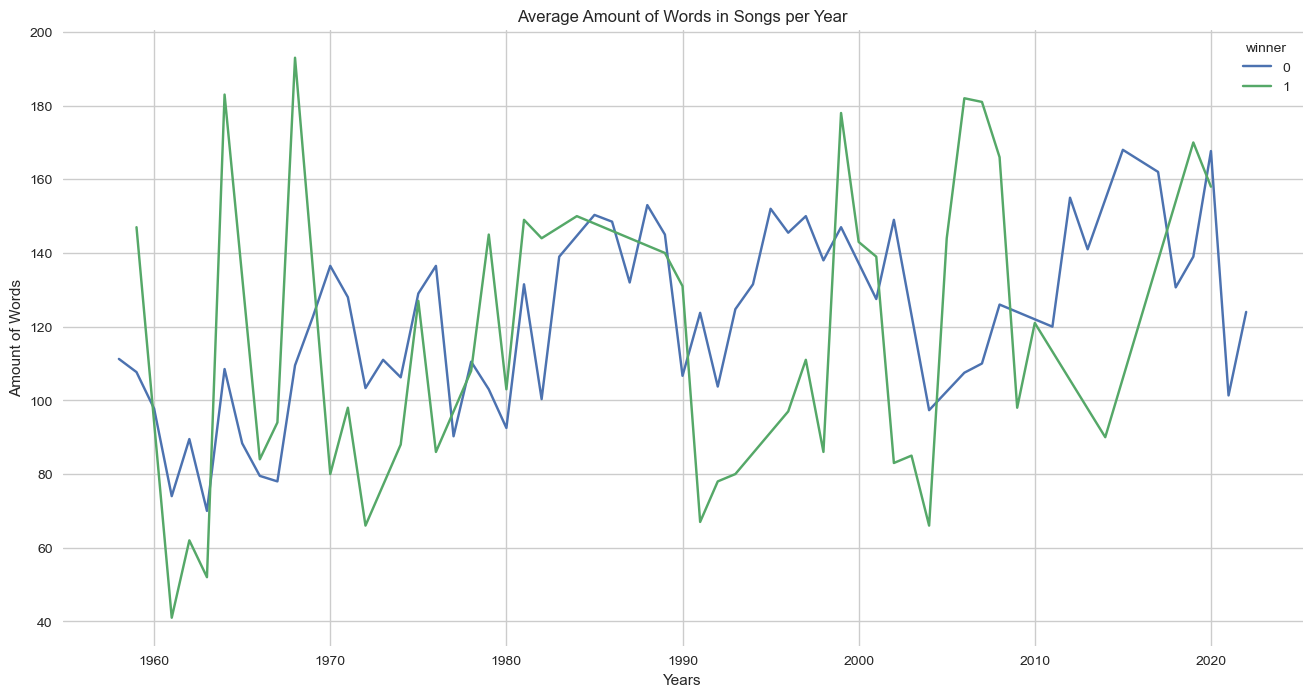

In [1265]:
# Plot the average word count for each year
plt.figure(figsize=(16,8))
sns.lineplot(data=df, x='year', y='lyrical_length', hue='winner', ci=None)
plt.title('Average Amount of Words in Songs per Year')
plt.xlabel('Years')
plt.ylabel('Amount of Words')
plt.show()


In [1266]:
def count_unique_words(lst):
    return len(set(lst))

# apply the function to create a new column
df['unique_word_count'] = df['preprocessed_lyrics'].apply(lambda x: count_unique_words(x))


/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_95196/1819790563.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='year', y='unique_word_count', hue='winner', ci=None)


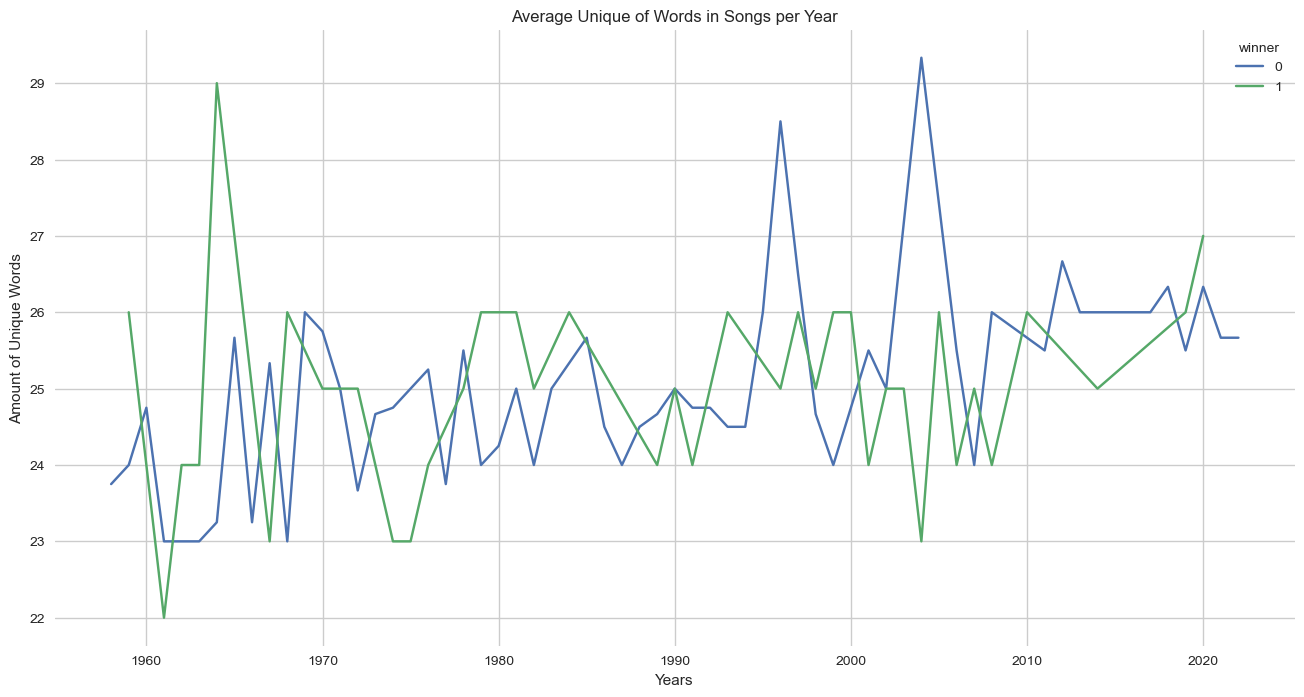

In [1267]:
# Plot the average amount of unique words each year
plt.figure(figsize=(16,8))
sns.lineplot(data=df, x='year', y='unique_word_count', hue='winner', ci=None)
plt.title('Average Unique of Words in Songs per Year')
plt.xlabel('Years')
plt.ylabel('Amount of Unique Words')
plt.show()


Profanity over the decades.

In [1268]:
# add decades detail
# Define the decade-to-year range mapping
decade_map = {'50s': (1950, 1960),
              '60s': (1960, 1970),
              '70s': (1970, 1980),
              '80s': (1980, 1990),
              '90s': (1990, 2000),
              '00s': (2000, 2010),
              '10s': (2010, 2020),
              '20s': (2020, 2030)}

# Apply the mapping using the `map()` method
def get_decade(year):
    for key, value in decade_map.items():
        if value[0] <= year < value[1]:
            return key
    return 'unknown'

df['decade'] = df['year'].apply(get_decade)

In [1269]:
decades = ['50s', '60s', '70s', '80s', '90s', '00s', '10s', '20s']
common_words = {}

for decade in decades:
    # Filter the DataFrame by decade
    df_decade = df.loc[df['decade'] == decade]
    # Join the cleaned lyrics of all songs in the decade
    for i in range(len(df_decade['preprocessed_lyrics'])):
        lyrics = ''.join(df_decade['preprocessed_lyrics'].iloc[0]).split()
    # Count the occurrences of each word and take the 200 most common words
        common_words[decade] = Counter(lyrics).most_common(200)

commonWords50 = common_words['50s']
commonWords60 = common_words['60s']
commonWords70 = common_words['70s']
commonWords80 = common_words['80s']
commonWords90 = common_words['90s']
commonWords00 = common_words['00s']
commonWords10 = common_words['10s']
commonWords20 = common_words['20s']

https://github.com/coffee-and-fun/google-profanity-words

In [1270]:
url  = 'https://raw.githubusercontent.com/coffee-and-fun/google-profanity-words/main/data/list.txt'
google_profanity_words = request.urlopen(url)

profane_words = []
for line in google_profanity_words:
    profane_words.append(line.decode("utf-8").strip())

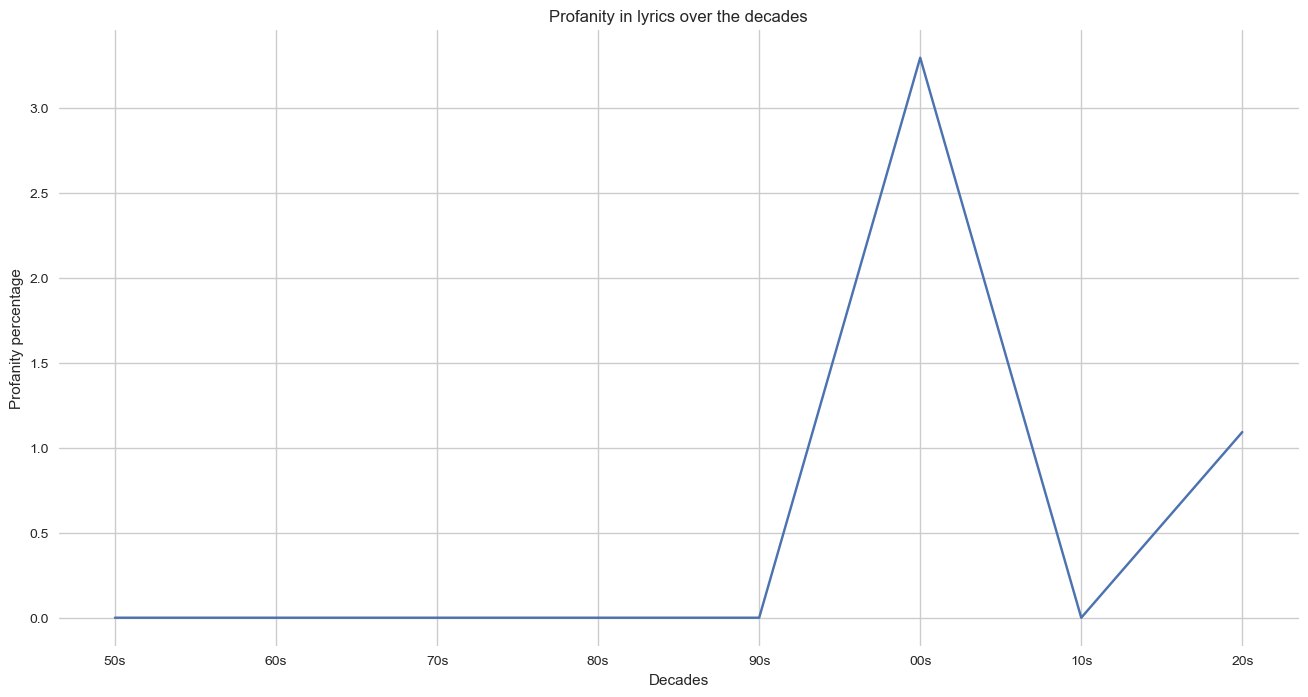

In [1271]:
commonWords = [commonWords50, commonWords60, commonWords70, commonWords80, commonWords90, commonWords00, commonWords10, commonWords20]
counts = []
for item in commonWords:
    totalCount = 0
    count = 0
    for key,value in item:
        if key in profane_words:
            count += value
        totalCount += value
    counts.append(count/totalCount * 100)

profanity_dict = {}
for i, decade in enumerate(decades):
    profanity_dict[decade] = counts[i]

profanity_df = pd.DataFrame.from_dict(profanity_dict, orient='index', columns=['Profanity Percentage'])

sns.set_style("whitegrid")
plt.figure(figsize=(16,8))
sns.lineplot(data=profanity_df, x=profanity_df.index, y='Profanity Percentage')
plt.title("Profanity in lyrics over the decades")
plt.xlabel("Decades")
plt.ylabel("Profanity percentage")
plt.show()




Wordcloud.

In [1272]:
winner_df = df[df.winner==1]
nominee_df = df[df.winner==0]

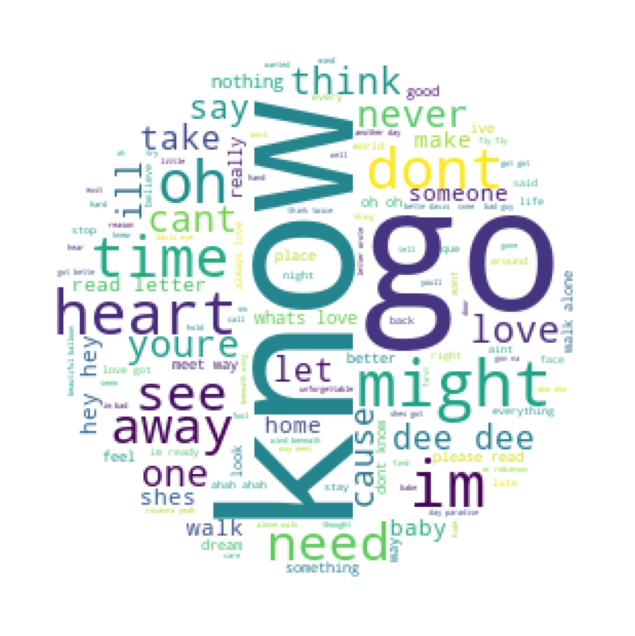

In [1273]:
#convert list to string and generate

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

unique_string = ''.join(winner_df['preprocessed_lyrics'].sum())
wordcloud = WordCloud(background_color="white",
                      mask=mask,
                      width = 1000,
                      height = 500).generate(unique_string)
plt.figure(figsize=(19,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

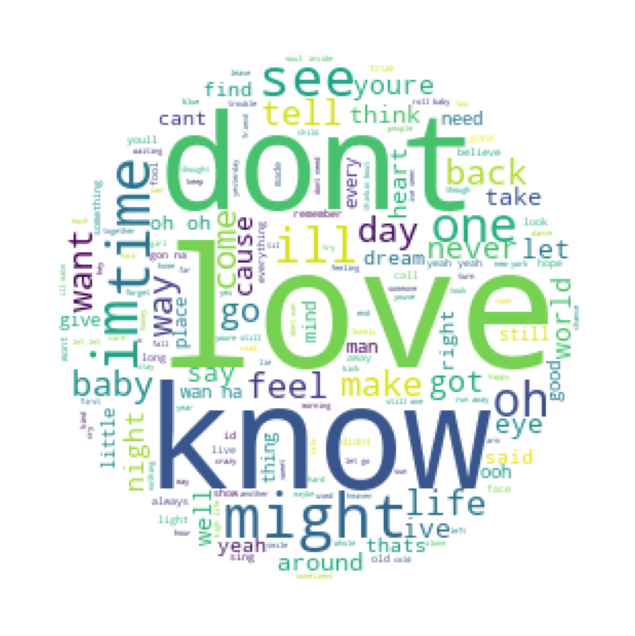

In [1274]:
#convert list to string and generate

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

unique_string = ''.join(nominee_df['preprocessed_lyrics'].sum())
wordcloud = WordCloud(background_color="white",
                      mask=mask,
                      width = 1000,
                      height = 500).generate(unique_string)
plt.figure(figsize=(19,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

Multiple Grammy winners.
Can you guess who has won more than 1 Grammy Best Record?

In [1275]:
dupes = df[df.winner==1]
dupes = dupes[dupes['artist'].duplicated(keep=False)]
dupes.sort_values('artist')

,title,artist,winner,year,song_lyrics,preprocessed_lyrics,language,anger_pct,anticipation_pct,disgust_pct,...,joy_pct,negative_pct,positive_pct,sadness_pct,surprise_pct,trust_pct,lyrical_length,gloom_index,unique_word_count,decade
310,Bad Guy,Billie Eilish,1,2019,TranslationsHrvatskiTürkçeSvenskaEspañolРусски...,traditionalbad guy white shirt red bloody nos...,en,3.151015,2.995487,2.941337,...,3.520815,3.001255,3.520815,3.379583,3.549416,3.449957,170,62.793838,26,10s
318,Everything I Wanted,Billie Eilish,1,2020,TranslationsTürkçeEspañolРусскийRomânăPortuguê...,bokml riksmlitalianobahasa indonesiamagyardeut...,en,2.393128,1.948833,2.932230,...,2.587194,2.991288,2.470907,3.081087,5.174387,0.000000,158,53.230286,27,20s
191,Change The World,Eric Clapton,1,1996,Change the World Lyrics If I could reach the s...,change world could reach star pull one shine ...,en,0.000000,2.935082,3.500411,...,2.384201,3.500411,2.751754,0.000000,2.746639,3.464970,97,0.000000,25,90s
171,Tears In Heaven,Eric Clapton,1,1992,Tears in Heaven Lyrics Would you know my name ...,tear heaven would know name saw heaven would ...,en,2.284016,2.622590,2.284016,...,4.663562,0.761339,4.663562,2.284016,4.327089,4.663562,78,19.605770,25,90s
26,Days Of Wine And Roses,Henry Mancini,1,1963,The Days of Wine and Roses LyricsThe days of w...,day wine rose sthe day wine rose laugh run awa...,en,3.277267,3.970414,3.277267,...,3.760886,3.277267,3.470530,3.277267,3.691043,3.439786,52,18.873198,24,60s
15,Moon River,Henry Mancini,1,1961,Moon River LyricsMoon River Wider than a mile ...,moon river smoon river wider mile im crossin s...,en,0.000000,0.000000,0.000000,...,3.137505,0.000000,3.137505,0.000000,0.000000,3.137505,41,0.000000,22,60s
51,Mrs. Robinson,Simon And Garfunkel,1,1968,Mrs. Robinson Lyrics Dee dee dee dee dee dee d...,mr robinson dee dee dee dee dee dee dee dee d...,en,4.108920,4.677169,3.576186,...,3.683893,3.576186,3.273546,2.384124,4.794369,4.317387,193,50.256045,26,60s
61,Bridge Over Troubled Water,Simon And Garfunkel,1,1970,Bridge Over Troubled Water Lyrics When you're ...,troubled water youre weary feeling small tea...,en,3.347508,1.790450,2.780641,...,2.576168,3.790427,2.273003,3.723238,3.277267,2.576168,80,32.769031,25,70s
211,Beautiful Day,U2,1,2000,TranslationsPortuguêsBeautiful Day Lyrics The ...,day heart bloom shoot stony ground there room...,en,4.524746,3.322392,0.000000,...,3.739977,2.782836,3.373650,3.198906,3.579797,4.049013,143,50.052036,26,00s
216,Walk On,U2,1,2001,Walk On Lyrics And love is not the easy thing ...,walk love easy thing baggage bring love easy ...,en,3.666789,2.423985,1.142008,...,3.893130,2.648343,4.080273,2.472004,3.191411,4.847444,139,37.604084,24,00s


Gloom Index by year.

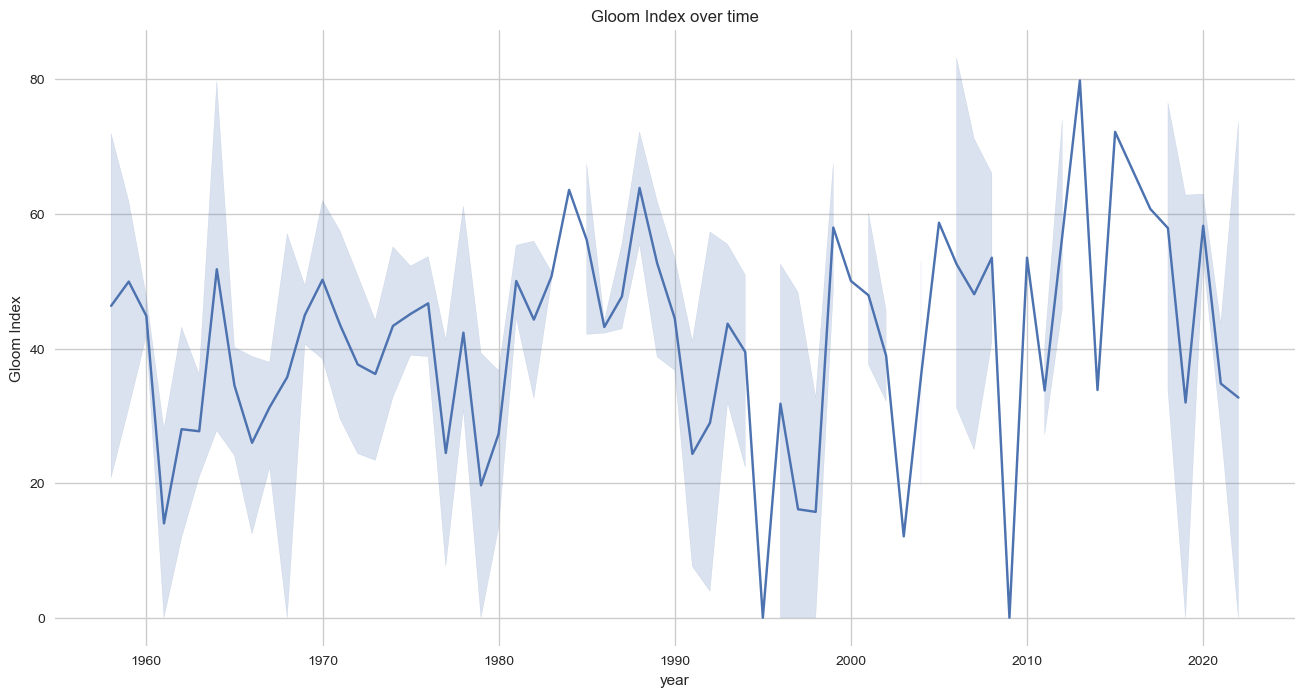

In [1276]:
plt.figure(figsize=(16,8))
tg = sns.lineplot(data=df, x='year', y='gloom_index');
tg.set_ylabel("Gloom Index")
tg.set_title("Gloom Index over time")
plt.show()



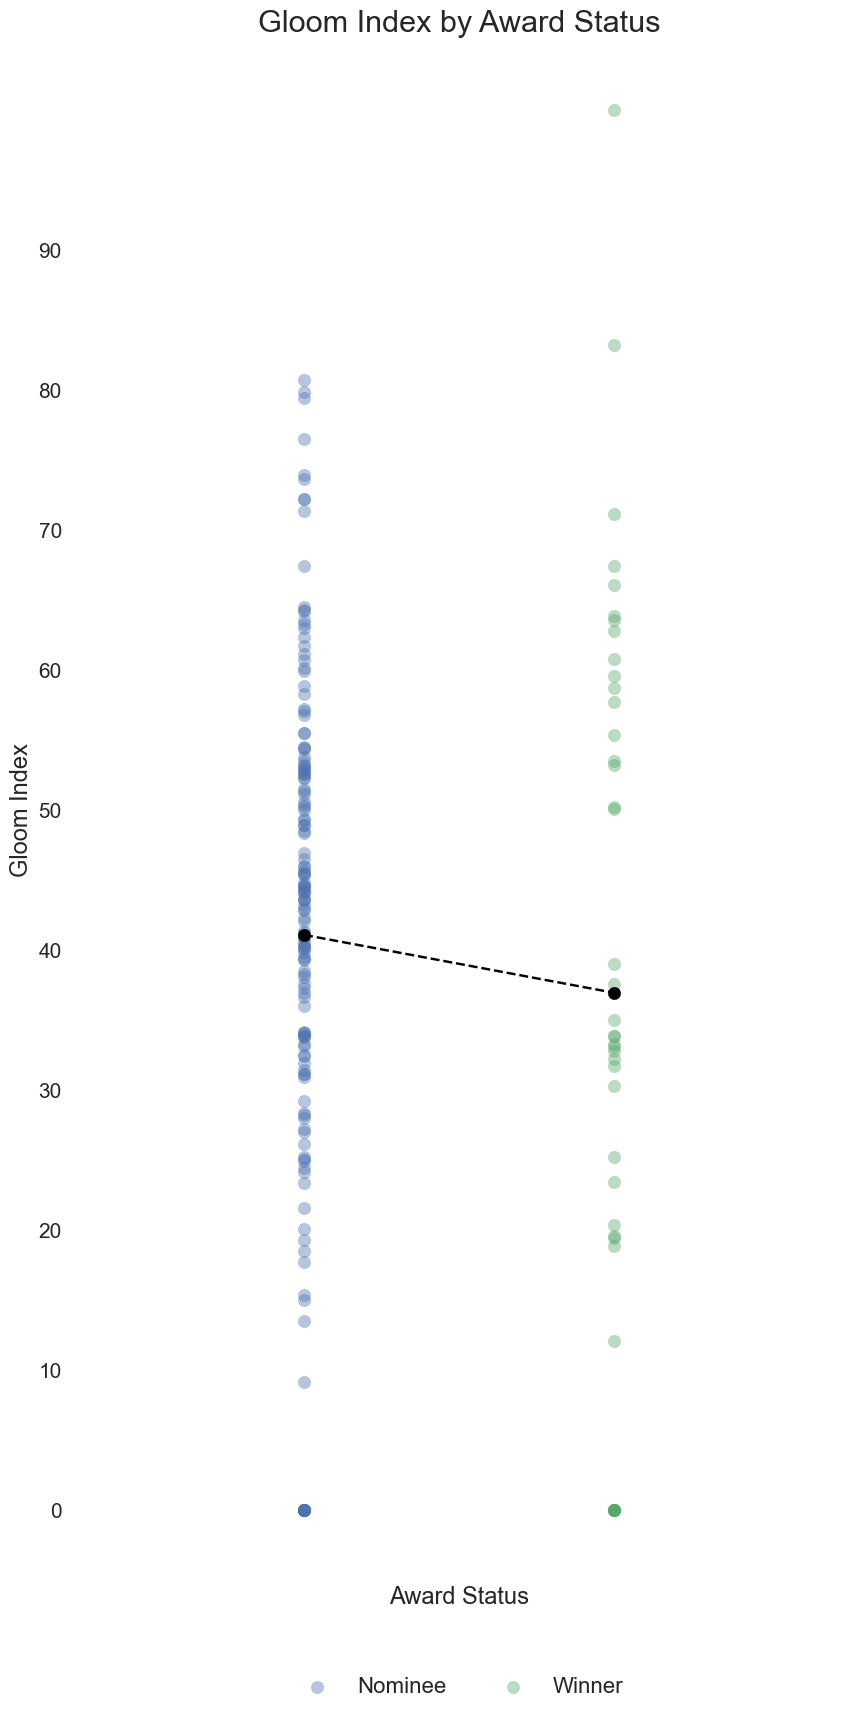

<module 'matplotlib.pyplot' from '/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [1277]:
from make_diff_graph import make_diff_graph
from make_time_graph import make_time_graph

make_diff_graph(df)

<module 'matplotlib.pyplot' from '/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

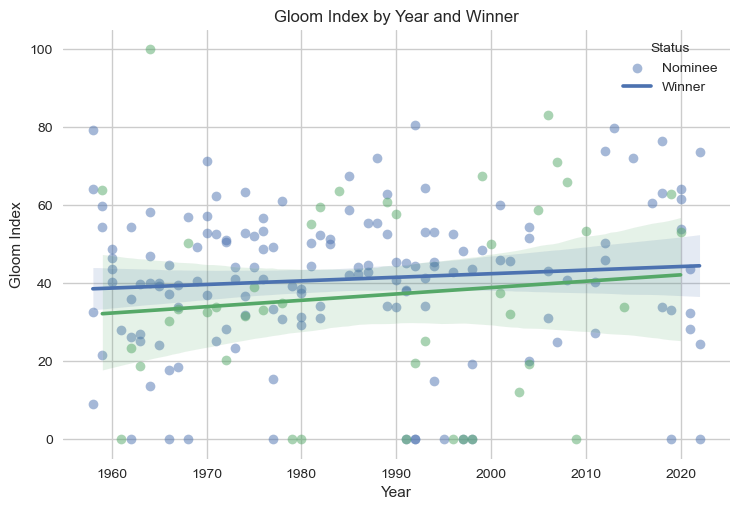

In [1278]:
make_time_graph(df)

*Predictions: correlation between sentiment percentages and Grammy wins* 

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_95196/1879319724.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df.corr(),


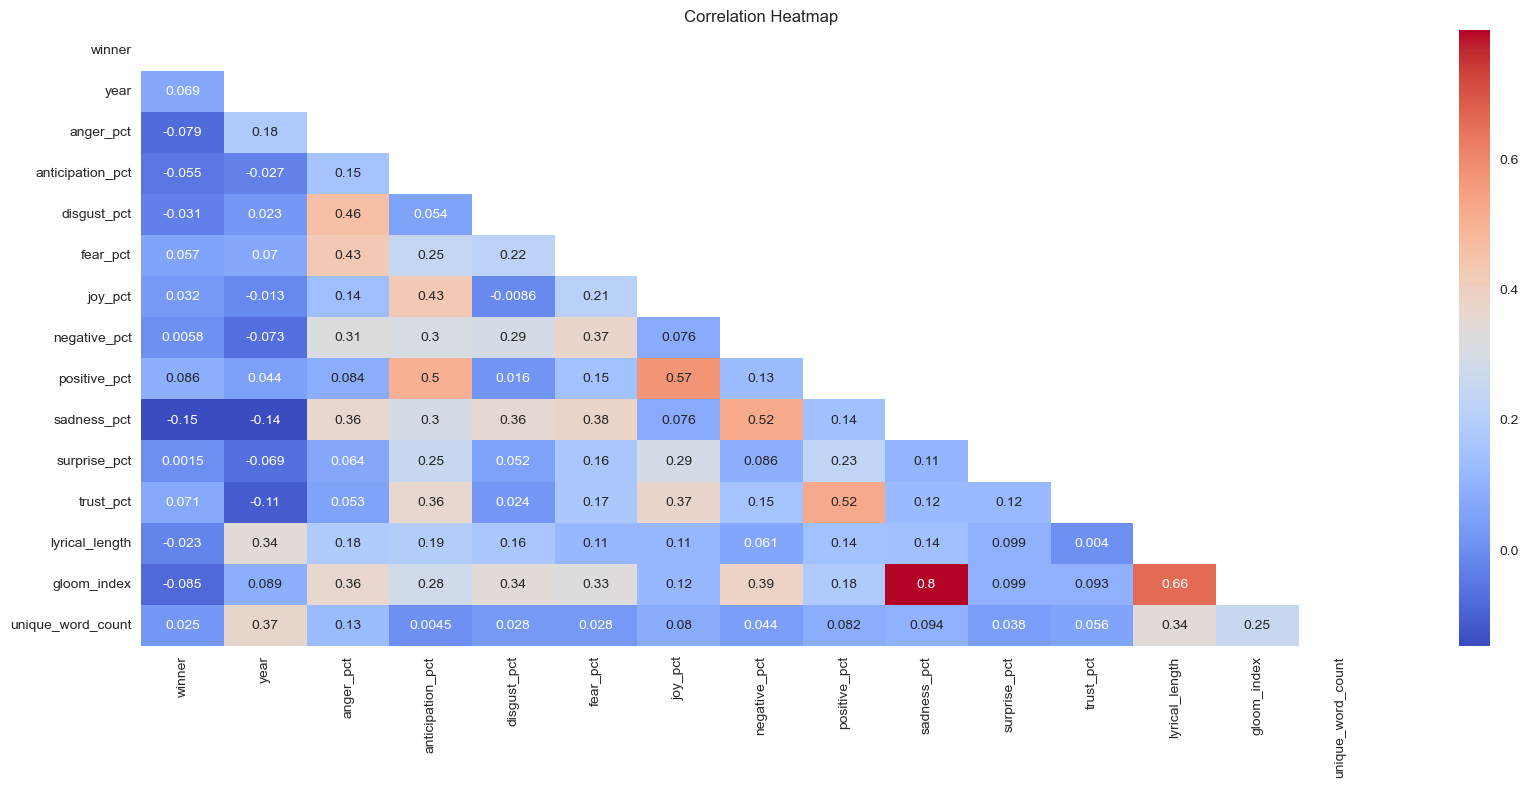

In [1279]:
plt.figure(figsize = (20, 8))
mask = np.triu(np.ones_like(df.corr(numeric_only=True), dtype=bool))
heatmap = sns.heatmap(df.corr(),
                      mask=mask,
                      annot=True,
                      cmap='coolwarm')
heatmap.set_title('Correlation Heatmap');

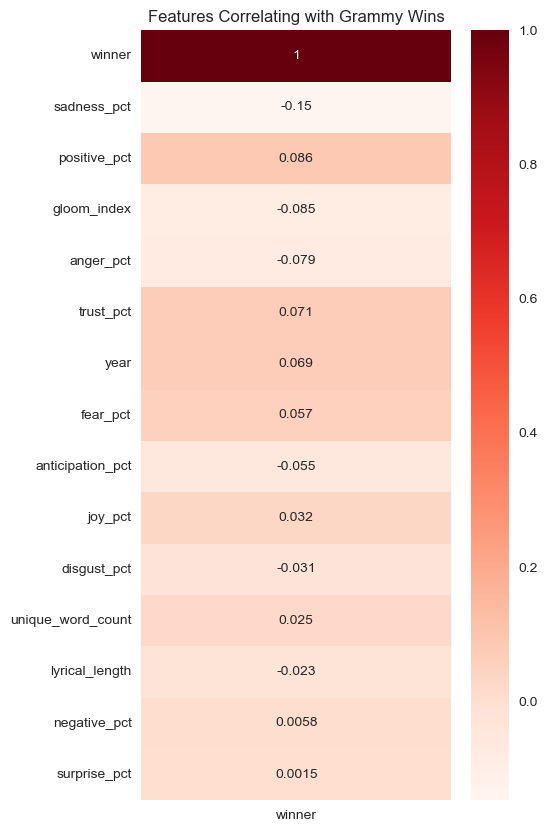

In [1280]:
top_features = df.corr(numeric_only=True)[['winner']].sort_values(by='winner', key = abs, ascending=False)
plt.figure(figsize=(5, 10))
heatmap = sns.heatmap(top_features,
                      annot=True,
                      cmap='Reds')
heatmap.set_title('Features Correlating with Grammy Wins');
plt.yticks(rotation=0);

## Model Prediction

In [1281]:
# split the data
X = df.drop(['winner', 'title', 'artist', 'song_lyrics', 'preprocessed_lyrics', 'language', 'decade'], axis=1) 
y = df["winner"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

# create a StandardScaler object and fit it to the training data
scaler = StandardScaler()
scaler.fit(X_train)

# use the scaler to transform the training and testing data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [1282]:
print(y_train.value_counts())

0    110
1     35
Name: winner, dtype: int64


In [1283]:
poly = PolynomialFeatures(degree=4)

X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

In [1284]:
# handling class imbalance with SMOTE 
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
print(y_train.value_counts())

In [1285]:
classifiers = [RandomForestClassifier(), SVC(kernel='linear'), DecisionTreeClassifier(), XGBClassifier()]

param_grids = [
    # Random Forest
    {'base_estimator__n_estimators': [50, 100, 200, 500], 'base_estimator__max_depth': [2, 4, 6, 8, 10]},
    
    # SVM
    {'base_estimator__C': [0.01, 0.1, 1, 10], 'base_estimator__gamma': ['scale', 'auto']},
    
    # Decision Tree
    {'base_estimator__criterion': ['gini', 'entropy'], 'base_estimator__max_depth': [2, 4, 6, 8, 10]},
    
    # XGBoost
    {'base_estimator__learning_rate': [0.01, 0.1, 0.5], 'base_estimator__max_depth': [2, 4, 6, 8], 'base_estimator__min_child_weight': [1, 3, 5], 'base_estimator__gamma': [0.0, 0.1, 0.2]}
]


metrics = [accuracy_score, roc_auc_score]

# loop over classifiers list
for idx, clf in enumerate(classifiers):
    print(f"Evaluating {clf.__class__.__name__}")
    
    # Wrap the classifier in CalibratedClassifierCV
    calibrated_clf = CalibratedClassifierCV(clf)
    
    # Create a HalvingGridSearchCV object with the calibrated classifier and hyperparameters
    clf_grid = HalvingGridSearchCV(calibrated_clf, param_grids[idx], cv=5, scoring='accuracy', n_jobs=-1)
    
    # fit HalvingGridSearchCV
    clf_grid.fit(X_train, y_train)
    
    # print the best hyperparameters and accuracy score
    print(f"Best hyperparameters: {clf_grid.best_params_}")
    print(f"Accuracy score: {clf_grid.best_score_:.4f}")
    
    # predict the test data
    y_pred = clf_grid.predict(X_test)

     # Loop over evaluation metrics and print score for each
    for metric in metrics:
        print(f"{metric.__name__}: {metric(y_test, y_pred):.4f}")
        
  # Calculate and plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label=f"Model {idx+1} (AUC = {roc_auc:.4f})")

# Set style and plot details
plt.style.use('seaborn')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()


Evaluating RandomForestClassifier
Best hyperparameters: {'base_estimator__max_depth': 6, 'base_estimator__n_estimators': 200}
Accuracy score: 0.9209
accuracy_score: 0.8367
roc_auc_score: 0.5000
Evaluating SVC
Best hyperparameters: {'base_estimator__C': 1, 'base_estimator__gamma': 'auto'}
Accuracy score: 0.8837
accuracy_score: 0.7143
roc_auc_score: 0.4771
Evaluating DecisionTreeClassifier
Best hyperparameters: {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 8}
Accuracy score: 0.8465
accuracy_score: 0.7143
roc_auc_score: 0.4771
Evaluating XGBClassifier
